### Постановка задачи

Вам предстоит определить к какому классу принадлежат изображения лиц: оригинальные кадры (real) или кадры, полученные при съемке экранов различными мобильными устройствами (spoof).

Базы Train и Test - это кадры из видеозаписей, снятых в различных условиях. Оригинальные видеозаписи получены с помощью веб-камер, камер мобильных телефонов или скачаны c Youtube. Атаки повторного воспроизведения получены путем съемки экранов различных ноутбуков и мониторов камерами мобильных телефонов в момент проигрывания оригинальных видеозаписей различных людей. Атаки были получены как в лабораторных условиях, так и с помощью исполнителей, зарегистрированных в краудсорсинговых интернет-сервисах Яндекс.Толока и Amazon Mechanical Turk.

Ссылка на Базу Train: https://drive.google.com/a/idrnd.net/file/d/1xmALNsYW-zm-Id9T6Ku2H4_cBWoqn23s

Ссылка на Базу Test: https://drive.google.com/a/idrnd.net/file/d/1teaLCo-F-5RCQM8Puxqbk13bI0evqIzg

Необходимо прислать на почту hr@idrnd.net ответы на файлы из Базы Test в следующем формате, где первый столбец - имя файла из тестовой выборки, а второй - вероятность класса real

0,2

7VOPPXVC.png,0.1409492673717314

U4WX0TBW.png,0.9453358419636287

...

PE6KMGCT.png,0.9453358419636287

### Краткое описание

Для решения данной задачи я решил использовать transfer learning, а конкретно - архитектуру Resnet с инициализированными весами. Для сравнения использовал две предобученные свёрточные нейронные сети (Resnet18 и Resnet50, c 18-ю и 50-ю скрытыми слоями соответственно). В первой итерации заморозил веса предобученной сети, обучал только выходной слой и получил ожидаемо плохой результат. Во второй итерации полностью переобучил модель Resnet18, используя предобученную сеть как отправную точку (Этот подход я подсмотрел у умных людей из Стэнфорда, занимавшихся классификацией меланом. Инициализация сети с предобученными весами вместо рандомных дала лучший результат в плане стоимости вычислений). Результат улучшился. В последней итерации делал всё тоже самое, что и во второй, только с сетью Resnet50. Более глубокая сеть показала ещё лучший результат. Для контроля обучения сети использовал валидацию. Задачу решал с помощью языка Python и фреймворка глубокого обучения Pytorch.

### Separating data into train and validation datasets

In [1]:
#Каждое десятое изображение будем использовать для валидации
from pathlib import Path
for i, file in enumerate(Path('train/real').glob('*.png')):
    if i % 10 == 0:
        file.replace(Path('valid/real') / file.name)     

In [3]:
for i, file in enumerate(Path('train/spoof').glob('*.png')):
    if i % 10 == 0:
        file.replace(Path('valid/spoof') / file.name)  

### Import nessesary libraries, creating dataloaders

In [1]:
#импортируем необходимые библиотеки
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from glob import glob
from collections import OrderedDict

In [2]:
#создаём загрузчики и трансформации для изображений
#для тренировочных данных используем дополнительные трансформации, рандомно переворачиваем изображения,
#чтобы сеть была более устойчива к искажённым данным 
train_dir = 'train/'
valid_dir = 'valid/'
random_transforms = [transforms.RandomAffine(45), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()]
train_transforms = transforms.Compose([transforms.RandomRotation(90),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomChoice(random_transforms),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

def loaders(dir_list, transforms_list, batch_size, num_workers, shuffle = True):
    #оборачиваю создание загрузчиков в фунцию для удобства
    train_dataset = datasets.ImageFolder(dir_list[0], transform = transforms_list[0])
    valid_dataset = datasets.ImageFolder(dir_list[1], transform = transforms_list[1])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
    loaders = {'train': trainloader, 'valid': validloader}
    return loaders

loaders = loaders(['train/', 'valid/'],[train_transforms, train_transforms] , 128, 0, True)

### Creating classifier, loading pretrained neural network

In [3]:
#использую GPU, объявляю модель и замораживаю параметры
use_cuda = torch.cuda.is_available()
model = models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
#меняю выходной слой на подходящий для данной задачи
hidden_dim = 512
out = 2
classifier = nn.Linear(hidden_dim, out)
model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#объявляю метрику оченки и алгоритм оптимизации нейронной сети
#поскольку данные несбалансированы, использую кросс-энтропию
#для оптимизации использую стохастический градиентный спуск
if use_cuda:
    print('Cuda is available!')
    model = model.cuda()
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr = 0.01, momentum = 0.9)

print(f"Num batches in trainloader: {len(loaders['train'])}\nNum of batches in validloader: {len(loaders['valid'])}")

Cuda is available!
Num batches in trainloader: 117
Num of batches in validloader: 13


### Training the model

In [3]:
#функция обучения
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    control_dict = {} #словарь контрольных значений ошибки для дальнейшей визуализации
    valid_loss_min = np.Inf #стартовый порог ошибки валидации для дальнейшего сохранения модели
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):#тренировка
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):#валидация
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        train_loss = train_loss / len(loaders['train'])
        valid_loss = valid_loss / len(loaders['valid'])
        print(f'Epoch: {epoch}\tTraining Loss: {train_loss}\tValidation Loss: {valid_loss}')
        #сохраняем модель если ошибка валидации уменьшилась
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss})')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        control_dict[epoch] = [train_loss, valid_loss]
        #возвращаем обученную модель и словарь контрольных значений
    return model, control_dict

In [34]:
trained_model, visual_data = train(100, loaders, model, optimizer, criterion, use_cuda, 'resnet18_pre.pt')

Epoch: 1	Training Loss: 53.36154275273873	Validation Loss: 30.92066474897521
Validation loss decreased (inf --> 30.92066474897521)
Epoch: 2	Training Loss: 33.04395294290478	Validation Loss: 26.449957553829467
Validation loss decreased (30.92066474897521 --> 26.449957553829467)
Epoch: 3	Training Loss: 31.90664438827563	Validation Loss: 31.491253459027835
Epoch: 4	Training Loss: 30.573314750093523	Validation Loss: 30.410379539643014
Epoch: 5	Training Loss: 29.48289444183899	Validation Loss: 29.416618402515137
Epoch: 6	Training Loss: 31.07864999771118	Validation Loss: 29.327967024807418
Epoch: 7	Training Loss: 29.273173869161283	Validation Loss: 27.346171587705612
Epoch: 8	Training Loss: 29.63161342578419	Validation Loss: 28.14865393936634
Epoch: 9	Training Loss: 30.10217875949407	Validation Loss: 26.821619876793452
Epoch: 10	Training Loss: 30.125515673120145	Validation Loss: 26.4187905980008
Validation loss decreased (26.449957553829467 --> 26.4187905980008)
Epoch: 11	Training Loss: 28.6

Epoch: 99	Training Loss: 29.0019929196875	Validation Loss: 45.2179020685809
Epoch: 100	Training Loss: 29.894874497995538	Validation Loss: 22.40082863186087
Validation loss decreased (22.495118326374463 --> 22.40082863186087)


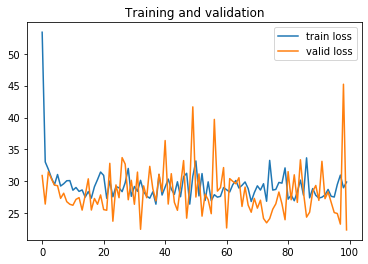

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
#функция для визуализации данных
def visualize(data):
    visual_data = np.array(list(data.values()))
    ax = np.arange(len(data)) 
    y_train = visual_data[:, 0] 
    y_valid = visual_data[:, 1]
    plt.plot(ax, y_train, label = 'train loss')
    plt.plot(ax, y_valid, label = 'valid loss')
    plt.title('Training and validation')
    plt.legend()
    plt.show()
    
visualize(visual_data)

### Full retraining of pretrained network

In [4]:
#используем более умный подход
use_cuda = torch.cuda.is_available()
hidden_dim = 512
out = 2
classifier = nn.Linear(hidden_dim, out)
model_1 = models.resnet18(pretrained = True)
model_1.fc = classifier
#т.к. данные сильно несбалансированные, штрафуем модель в большей степени за ошибки классификации в классе меньшинства
#для этого объявляем тензор с соотношениями штрафов и добавляем его как аргумент в метрику оценки
weights = torch.tensor([1101 / 7470, 6369 / 7470], dtype=torch.float, device='cuda:0')
criterion_1 = nn.CrossEntropyLoss(weight = weights)
optimizer_1 = optim.SGD(model_1.parameters(), lr = 0.001, momentum = 0.9)
if use_cuda:
    print('Cuda is available!')
    model_1 = model_1.cuda()

Cuda is available!


In [5]:
trained_model_1, visual_data_1 = train(100, loaders, model_1, optimizer_1, criterion_1, use_cuda, 'resnet18_fullretr.pt')

Epoch: 1	Training Loss: 28.287601215859592	Validation Loss: 15.779209473303386
Validation loss decreased (inf --> 15.779209473303386)
Epoch: 2	Training Loss: 15.152543220984734	Validation Loss: 13.49432231166533
Validation loss decreased (15.779209473303386 --> 13.49432231166533)
Epoch: 3	Training Loss: 13.74818556238029	Validation Loss: 12.379001486514296
Validation loss decreased (13.49432231166533 --> 12.379001486514296)
Epoch: 4	Training Loss: 12.684030973557698	Validation Loss: 11.178703961627823
Validation loss decreased (12.379001486514296 --> 11.178703961627823)
Epoch: 5	Training Loss: 11.749736883125063	Validation Loss: 10.560557522944041
Validation loss decreased (11.178703961627823 --> 10.560557522944041)
Epoch: 6	Training Loss: 10.749064665224592	Validation Loss: 10.212305476622921
Validation loss decreased (10.560557522944041 --> 10.212305476622921)
Epoch: 7	Training Loss: 9.57147050686812	Validation Loss: 8.868989136602197
Validation loss decreased (10.212305476622921 -->

Epoch: 82	Training Loss: 1.36972019155273	Validation Loss: 1.184167890144246
Epoch: 83	Training Loss: 1.2585748662635432	Validation Loss: 1.591854662235294
Epoch: 84	Training Loss: 1.1492332500105693	Validation Loss: 1.095681733850922
Validation loss decreased (1.1772704630025796 --> 1.095681733850922)
Epoch: 85	Training Loss: 1.0689695740150194	Validation Loss: 1.488914173894695
Epoch: 86	Training Loss: 1.418469662825435	Validation Loss: 1.2543967360231494
Epoch: 87	Training Loss: 1.2509113467393158	Validation Loss: 2.310763733328453
Epoch: 88	Training Loss: 1.243436757411997	Validation Loss: 1.214844441773104
Epoch: 89	Training Loss: 1.3548800270941297	Validation Loss: 0.7966697090970618
Validation loss decreased (1.095681733850922 --> 0.7966697090970618)
Epoch: 90	Training Loss: 0.9422101451190568	Validation Loss: 0.9891682589160544
Epoch: 91	Training Loss: 0.9850217746333929	Validation Loss: 1.5075572920697076
Epoch: 92	Training Loss: 1.1208405781032171	Validation Loss: 1.357898001

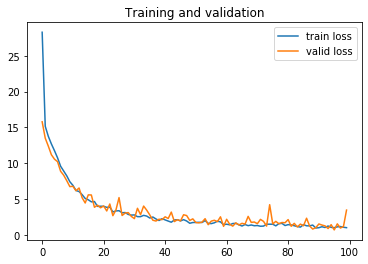

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(data):
    visual_data = np.array(list(data.values()))
    ax = np.arange(len(data)) 
    y_train = visual_data[:, 0] 
    y_valid = visual_data[:, 1]
    plt.plot(ax, y_train, label = 'train loss')
    plt.plot(ax, y_valid, label = 'valid loss')
    plt.title('Training and validation')
    plt.legend()
    plt.show()
    
visualize(visual_data_1)

### Retraining with imbalanced weights

In [3]:
train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
print(train_dataset.classes)

['real', 'spoof']


In [4]:
hidden_dim = 2048
out = 2
classifier = nn.Linear(hidden_dim, out)
use_cuda = torch.cuda.is_available()

In [5]:
#испытываем более глубокую сеть, немного меняем гиперпараметры
model_2 = models.resnet50(pretrained = True)
model_2.fc = classifier
weights = torch.tensor([1101 / 7470, 6369 / 7470], dtype=torch.float, device='cuda:0')
criterion_2 = nn.CrossEntropyLoss(weight = weights)
optimizer_2 = optim.SGD(model_2.parameters(), lr = 0.005, momentum = 0.85)
if use_cuda:
    print('Cuda is available!')
    model_2 = model_2.cuda()

Cuda is available!


In [8]:
trained_model_2, visual_data_2 = train(50, loaders, model_2, optimizer_2, criterion_2, use_cuda, 'resnet50_imba.pt')

Epoch: 1	Training Loss: 3.119493985341655	Validation Loss: 2.1565372160134406
Validation loss decreased (inf --> 2.1565372160134406)
Epoch: 2	Training Loss: 1.4333462505004344	Validation Loss: 0.9463226368220953
Validation loss decreased (2.1565372160134406 --> 0.9463226368220953)
Epoch: 3	Training Loss: 1.1036953940096064	Validation Loss: 1.0202928092330694
Epoch: 4	Training Loss: 0.9176757484793854	Validation Loss: 0.8146104342662371
Validation loss decreased (0.9463226368220953 --> 0.8146104342662371)
Epoch: 5	Training Loss: 0.8080139377783252	Validation Loss: 0.713044434445552
Validation loss decreased (0.8146104342662371 --> 0.713044434445552)
Epoch: 6	Training Loss: 0.561203756984562	Validation Loss: 0.487677765222123
Validation loss decreased (0.713044434445552 --> 0.487677765222123)
Epoch: 7	Training Loss: 0.6512862141084913	Validation Loss: 0.370174420496019
Validation loss decreased (0.487677765222123 --> 0.370174420496019)
Epoch: 8	Training Loss: 0.5088192163687996	Validatio

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(data):
    visual_data = np.array(list(data.values()))
    ax = np.arange(len(data)) 
    y_train = visual_data[:, 0] 
    y_valid = visual_data[:, 1]
    plt.plot(ax, y_train, label = 'train loss')
    plt.plot(ax, y_valid, label = 'valid loss')
    plt.title('Training and validation')
    plt.legend()
    plt.show()

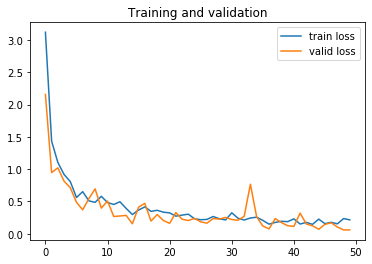

In [10]:
visualize(visual_data_2)

### Making predictions

In [8]:
from PIL import Image
from PIL import ImageFile
import pandas as pd

train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
class_names = train_dataset.classes
print(class_names)

['real', 'spoof']


In [11]:
hidden_dim = 2048
out = 2
classifier = nn.Linear(hidden_dim, out)
resnet50 = models.resnet50(pretrained = True)
resnet50.fc = classifier
resnet50.load_state_dict(torch.load('resnet50_imba.pt'))

<All keys matched successfully>

In [13]:
resnet50.class_to_idx = train_dataset.class_to_idx
#используем модель для предсказания результатов
def process_image(image):
    #трансформитуем изображение для нейронной сети
    resizing = transforms.Compose([transforms.Resize(255),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    result = resizing(image)
    return np.array(result)

def predict(image_path, model, topk=2):
    #функция для предсказания результатов
    device = torch.device("cpu")
    model.to(device)
    model.eval()
    
    img_open = Image.open(image_path) 
    img_processed = process_image(img_open)
    img_torch = torch.from_numpy(img_processed)
    
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch)
        
    probability = F.softmax(output.data,dim=1)
    
    probs = np.array(probability.topk(topk)[0][0])
    
    index_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [np.str(index_to_class[each]) for each in np.array(probability.topk(topk)[1][0])]
    
    return probs, top_classes

In [14]:
probs, classes = predict('valid/real/HTCD620_id117_s0_120.png', resnet50)
print(probs)
print(classes)
probs, classes = predict('valid/real/YOUTUBE_id22_s0_38.png', resnet50)
print(probs)
print(classes)
probs, classes = predict('valid/real/YOUTUBE_id68_s0_150.png', resnet50)
print(probs)
print(classes)
probs, classes = predict('valid/spoof/FT720P_IIYAMAGB_IPHONE5SB_id1_s0_120.png', resnet50)
print(probs)
print(classes)
probs, classes = predict('valid/spoof/FT720P_MBP1314_IPHONE7F_id3_s0_120.png', resnet50)
print(probs)
print(classes)
probs, classes = predict('valid/spoof/YOUTUBE_ATMP253MG_XIAOMIMI6_id33_s0_113.png', resnet50)
print(probs)
print(classes)

[9.9998951e-01 1.0532335e-05]
['real', 'spoof']
[0.968271   0.03172898]
['real', 'spoof']
[9.9978131e-01 2.1873912e-04]
['real', 'spoof']
[9.9999940e-01 5.3678997e-07]
['spoof', 'real']
[1.0000000e+00 2.1952514e-08]
['spoof', 'real']
[9.9999702e-01 2.9740324e-06]
['spoof', 'real']


In [15]:
columns = ['image_name', 'spoof_prob']
test_csv = pd.DataFrame(columns = columns)
test_csv

,image_name,spoof


In [16]:
from pathlib import Path
for i, file in enumerate(Path('test').glob('*.png')):
    probs, classes = predict('test/' + file.name, resnet50)
    test_csv.loc[i] = [file.name] + [probs[classes.index('spoof')]]

In [17]:
print(test_csv.head())
test_csv.to_csv('test_csv.csv', index = False)

     image_name     spoof
0  0004TGCC.png  1.000000
1  00BMIGHK.png  1.000000
2  00DH97CQ.png  0.000263
3  00GZOF2Z.png  0.001169
4  00I3IO2B.png  1.000000
